In [2]:
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook: ', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook:  3.8.8


#Carga de Dados Executada com VirtualEnv
#python -m venv venv
#pipenv install imdb-sqlite
#imdb-sqlite

In [3]:
%pip install -q pycountry

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [4]:
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')

In [5]:
conn = sqlite3.connect('imdb.db')
tabelas = pd.read_sql_query("select name as 'Table_Name' from sqlite_master where type='table'", conn)

In [7]:
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [8]:
tabelas = tabelas['Table_Name'].values.tolist()
for tabela in tabelas:
    consulta = f"pragma table_info({tabela})"
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela: ", tabela)
    display(resultado)
    print("-"*100 + "\n")

Esquema da tabela:  people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------



**1- Quais são as categorias de Filmes mais comuns no IMDB?**

In [9]:
consulta1 = '''select type, count(*) as count from titles group by type'''

In [10]:
resultado1 = pd.read_sql_query(consulta1, conn)
display(resultado1)

,type,count
0,movie,602910
1,short,857469
2,tvEpisode,6526093
3,tvMiniSeries,42239
4,tvMovie,135095
5,tvPilot,2
6,tvSeries,221542
7,tvShort,10466
8,tvSpecial,36040
9,video,257670


In [11]:
resultado1['percentual'] = (resultado1['count']/resultado1['count'].sum()) * 100
display(resultado1)

,type,count,percentual
0,movie,602910,6.914078
1,short,857469,9.833321
2,tvEpisode,6526093,74.840216
3,tvMiniSeries,42239,0.484390
4,tvMovie,135095,1.549248
5,tvPilot,2,0.000023
6,tvSeries,221542,2.540609
7,tvShort,10466,0.120022
8,tvSpecial,36040,0.413301
9,video,257670,2.954919


In [12]:
#Grafico com 4 categorias
others = {}
others['count'] = resultado1[resultado1['percentual'] < 5]['count'].sum()
others['percentual'] = resultado1[resultado1['percentual'] < 5]['percentual'].sum()
others['type'] = 'others'
others

{'count': 733563, 'percentual': 8.412385959460025, 'type': 'others'}

In [13]:
resultado1 = resultado1[resultado1['percentual'] > 5]
resultado1 = resultado1.append(others, ignore_index=True)
resultado1 = resultado1.sort_values(by='count', ascending=False)
resultado1.head()

,type,count,percentual
2,tvEpisode,6526093,74.840216
1,short,857469,9.833321
3,others,733563,8.412386
0,movie,602910,6.914078


In [15]:
labels = [str(resultado1['type'][i])+' '+'['+ str(round(resultado1['percentual'][i],2)) +'%]' for i in resultado1.index]

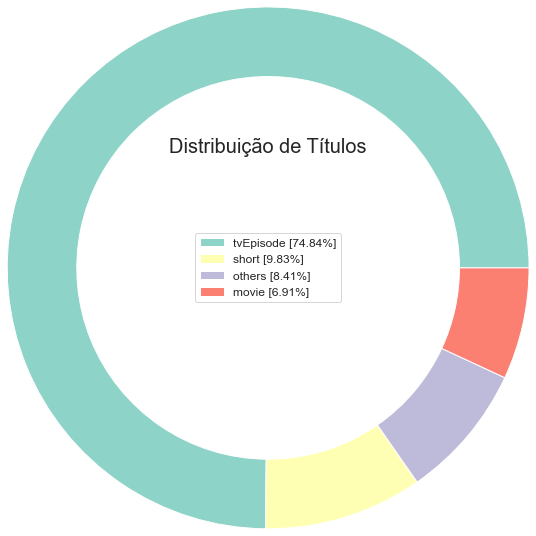

In [23]:
cs = cm.Set3(np.arange(100))
plt.pie(resultado1['count'], labeldistance=1, radius=3, colors=cs, wedgeprops=dict(width=0.8))
plt.legend(labels=labels, loc='center', prop={'size':12})
plt.title('Distribuição de Títulos', loc='center', fontdict={'fontsize':20,'fontweight':20})
plt.show()

**2- Qual o Número de Títulos Por Gênero?**

In [25]:
consulta2 = '''select genres, count(*) as count from titles where type='movie' group by genres'''
resultado2 = pd.read_sql_query(consulta2, conn)
display(resultado2)

,genres,count
0,Action,13837
1,"Action,Adult",11
2,"Action,Adult,Adventure",2
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1446,"Thriller,Western",43
1447,War,1288
1448,"War,Western",14
1449,Western,5103


In [26]:
resultado2['genres'] = resultado2['genres'].str.lower().values
temp = resultado2['genres'].dropna()

In [27]:
padrao = '(?u)\\b[\\w-]+\\b'
vetor = CountVectorizer(token_pattern=padrao, analyzer='word').fit(temp)
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [33]:
bag_generos = vetor.transform(temp)
type(bag_generos)

scipy.sparse.csr.csr_matrix

In [30]:
generos_unicos = vetor.get_feature_names()
generos = pd.DataFrame(bag_generos.todense(), columns=generos_unicos, index=temp.index)
generos = generos.drop(columns='n', axis=0)
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 0 to 1450
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1451 non-null   int64
 1   adult        1451 non-null   int64
 2   adventure    1451 non-null   int64
 3   animation    1451 non-null   int64
 4   biography    1451 non-null   int64
 5   comedy       1451 non-null   int64
 6   crime        1451 non-null   int64
 7   documentary  1451 non-null   int64
 8   drama        1451 non-null   int64
 9   family       1451 non-null   int64
 10  fantasy      1451 non-null   int64
 11  film-noir    1451 non-null   int64
 12  game-show    1451 non-null   int64
 13  history      1451 non-null   int64
 14  horror       1451 non-null   int64
 15  music        1451 non-null   int64
 16  musical      1451 non-null   int64
 17  mystery      1451 non-null   int64
 18  news         1451 non-null   int64
 19  reality-tv   1451 non-null   int64
 20  romance 

In [31]:
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending=False) / generos.shape[0]
generos_percentual.head(10)

drama          18.194349
comedy         16.815989
documentary    15.851137
adventure      14.817367
action         14.403859
romance        13.370090
crime          13.094418
mystery        12.474156
thriller       12.336320
fantasy        12.198484
dtype: float64

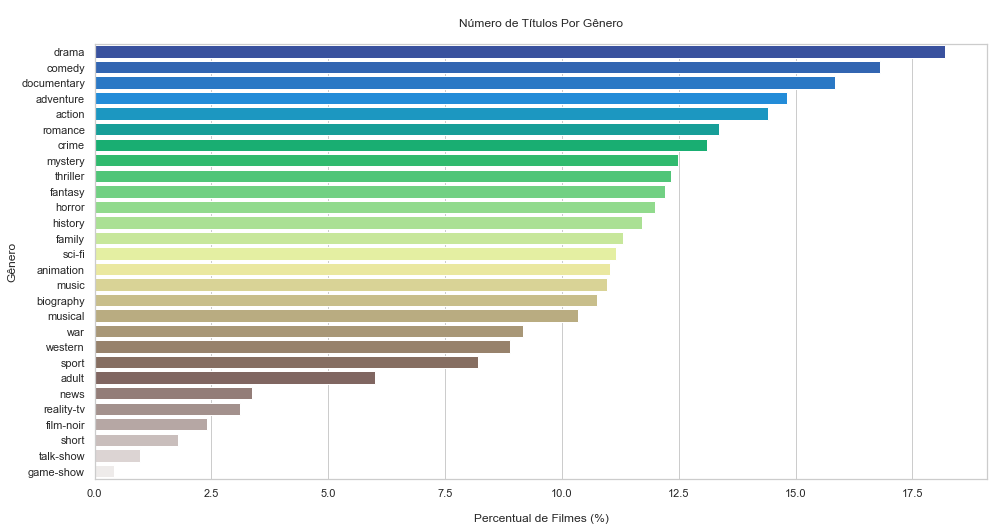

In [37]:
plt.figure(figsize=(16,8))
sns.barplot(x=generos_percentual.values, y=generos_percentual.index, orient='h', palette='terrain')
plt.ylabel('Gênero')
plt.xlabel('\nPercentual de Filmes (%)')
plt.title('\nNúmero (Percentual) de Títulos Por Gênero\n')
plt.show()

**3- Qual a Mediana de Avaliação dos Filmes Por Gênero?**

In [44]:
consulta3 = '''
    select rating, genres from
    ratings join titles on ratings.title_id = titles.title_id
    where premiered <= 2022 and type='movie' 
'''
resultado3 = pd.read_sql_query(consulta3, conn)

In [45]:
print(type(resultado3))
display(resultado3)

<class 'pandas.core.frame.DataFrame'>


,rating,genres
0,4.5,\N
1,6.1,"Action,Adventure,Biography"
2,4.6,Drama
3,4.5,Drama
4,3.8,Drama
...,...,...
275169,5.8,Thriller
275170,6.4,"Drama,History"
275171,3.8,"Adventure,History,War"
275172,8.3,Drama


In [46]:
def retorna_generos(df :pd.DataFrame):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b', analyzer='word').fit(temp)
    generos_unicos = vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre)>1]
    return generos_unicos

In [47]:
generos_unicos = retorna_generos(resultado3)
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [54]:
genero_counts = []
genero_ratings = []
for item in generos_unicos:
    consulta = 'select count(rating) from ratings join titles on ratings.title_id = titles.title_id where genres like '+'\'%'+ item +'%\''+' and type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])

    consulta = 'select rating from ratings join titles on ratings.title_id = titles.title_id where genres like '+'\'%'+ item +'%\''+' and type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating']))

In [55]:
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings
df_genero_ratings.head(20)

,genres,count,rating
0,action,28523,5.8
1,adult,4307,5.9
2,adventure,17297,6.0
3,animation,4731,6.6
4,biography,8302,7.0
5,comedy,68171,6.0
6,crime,23494,6.1
7,documentary,40843,7.3
8,drama,121898,6.3
9,family,10647,6.3


In [56]:
df_genero_ratings = df_genero_ratings.drop(index=18)
df_genero_ratings = df_genero_ratings.sort_values(by='rating', ascending=False)

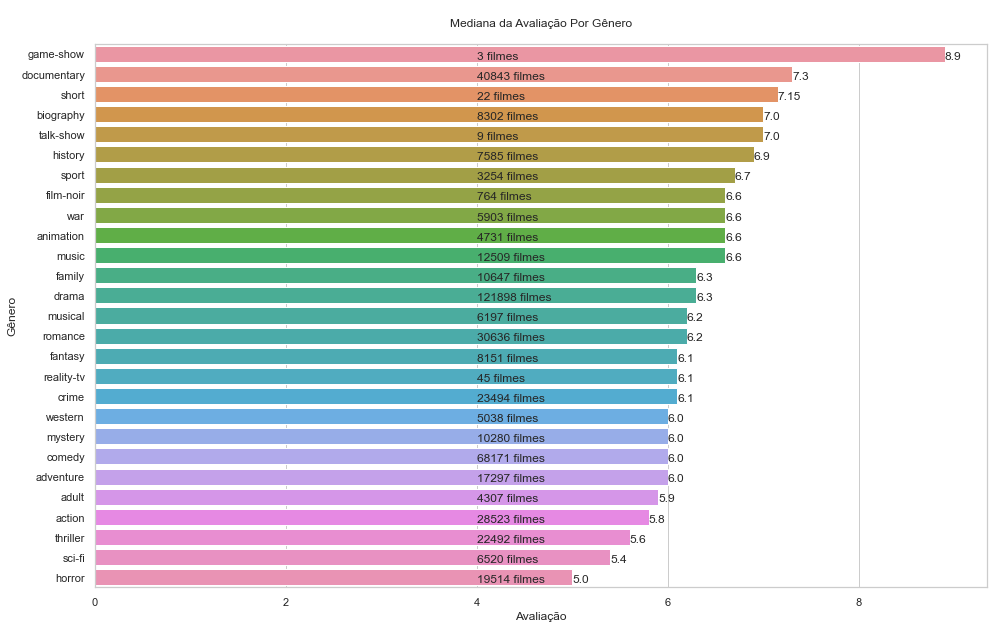

In [60]:
plt.figure(figsize=(16,10))
sns.barplot(y=df_genero_ratings.genres, x=df_genero_ratings.rating, orient='h')
for i in range(len(df_genero_ratings.index)):
    plt.text(4.0, i+0.25, str(df_genero_ratings['count'][df_genero_ratings.index[i]])+' filmes')
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]], i+0.25, round(df_genero_ratings.rating[df_genero_ratings.index[i]], 2))

plt.ylabel('Gênero')
plt.xlabel('Avaliação')
plt.title('\nMediana da Avaliação Por Gênero\n')
plt.show()

**4- Qual a Mediana de Avaliação de Filmes em Relação ao Ano de Estréia?**

In [61]:
consulta4 = '''
    select rating, premiered from
    ratings join titles on ratings.title_id = titles.title_id
    where premiered <= 2022 and type = 'movie'
    order by premiered
    '''
resultado4 = pd.read_sql_query(consulta4, conn)
display(resultado4)

,rating,premiered
0,6.2,1896
1,4.5,1897
2,4.0,1899
3,3.7,1899
4,6.0,1900
...,...,...
275169,3.7,2022
275170,4.0,2022
275171,10.0,2022
275172,6.1,2022


In [62]:
ratings = []
for year in set(resultado4['premiered']):
    ratings.append(np.median(resultado4[resultado4['premiered'] == year]['rating']))
type(ratings)

list

In [63]:
ratings[1:10]

[4.5, 3.85, 5.85, 4.6, 3.5, 4.6, 5.4, 4.5, 3.6]

In [64]:
years = list(set(resultado4['premiered']))
years[1:10]

[1897, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906]

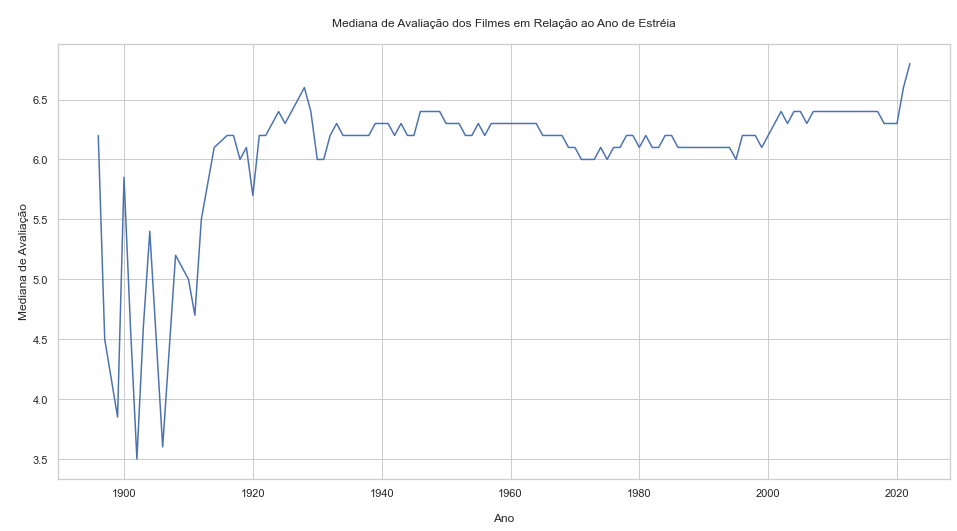

In [65]:
plt.figure(figsize=(16,8))
plt.plot(years, ratings)
plt.xlabel('\nAno')
plt.ylabel('\nMediana de Avaliação')
plt.title('\nMediana de Avaliação dos Filmes em Relação ao Ano de Estréia\n')
plt.show()

**5- Qual o Número de Filmes Avaliados Por Gênero em Relação ao Ano de Estréia?**